In [196]:
import pandas as pd
from pathlib import Path
from typing import Tuple
from itertools import product
from collections import defaultdict
import pandas as pd
import numpy as np
import json
from scipy import stats
from math import sqrt
from enum import Enum
from dataclasses import dataclass
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator, AutoMinorLocator, FormatStrFormatter
import matplotlib.pyplot as plt
import seaborn as sns
import upsetplot

plt.style.use("ggplot")
FIGSIZE = (13, 8)
DPI = 300

In [197]:
summary_files = list(Path("../../results/novel/assessment/").rglob("*.json"))

In [198]:
data = []
columns = ["sample", "tech", "precision", "recall", "FN", "FP", "TP", "CSI"]
for p in summary_files:
    d = json.loads(p.read_text())
    sample = p.parts[-2]
    tech = p.parts[-4]

    precision = float(d["Precision"]["Precision_edit_dist"])
    fps = int(d["Precision"]["FP"]["Count"])
    recall = float(d["Recall"]["Recall_edit_dist"])
    fns = int(d["Recall"]["FN"]["Count"])
    tps = int(d["Recall"]["TP"]["Count"])
    try:
        csi = tps/(tps+fps+fns)
    except ZeroDivisionError:
        csi=None
    data.append((sample, tech, precision, recall, fns, fps, tps, csi))
df = pd.DataFrame(data, columns=columns)

In [199]:
df

,sample,tech,precision,recall,FN,FP,TP,CSI
0,18_0621851,nanopore,0.0,1.000000,0,3,2,0.400000
1,18_0622434,nanopore,0.0,0.800000,1,5,4,0.400000
2,18_0622365,nanopore,0.0,1.000000,0,1,1,0.500000
3,18_0622300,nanopore,0.0,0.666667,1,3,2,0.333333
4,17_616026,nanopore,0.0,1.000000,0,3,3,0.500000
...,...,...,...,...,...,...,...,...
295,R27657,illumina,0.0,0.666667,1,2,2,0.400000
296,R26778,illumina,0.0,1.000000,0,2,2,0.500000
297,R21839,illumina,0.0,0.750000,1,3,3,0.428571
298,R18040,illumina,0.0,1.000000,0,2,2,0.500000


In [200]:
counts = df.drop(columns=["recall", "precision", "CSI"]).melt(id_vars=["sample", "tech"], var_name="classification", value_name="count")
counts

,sample,tech,classification,count
0,18_0621851,nanopore,FN,0
1,18_0622434,nanopore,FN,1
2,18_0622365,nanopore,FN,0
3,18_0622300,nanopore,FN,1
4,17_616026,nanopore,FN,0
...,...,...,...,...
895,R27657,illumina,TP,2
896,R26778,illumina,TP,2
897,R21839,illumina,TP,3
898,R18040,illumina,TP,2


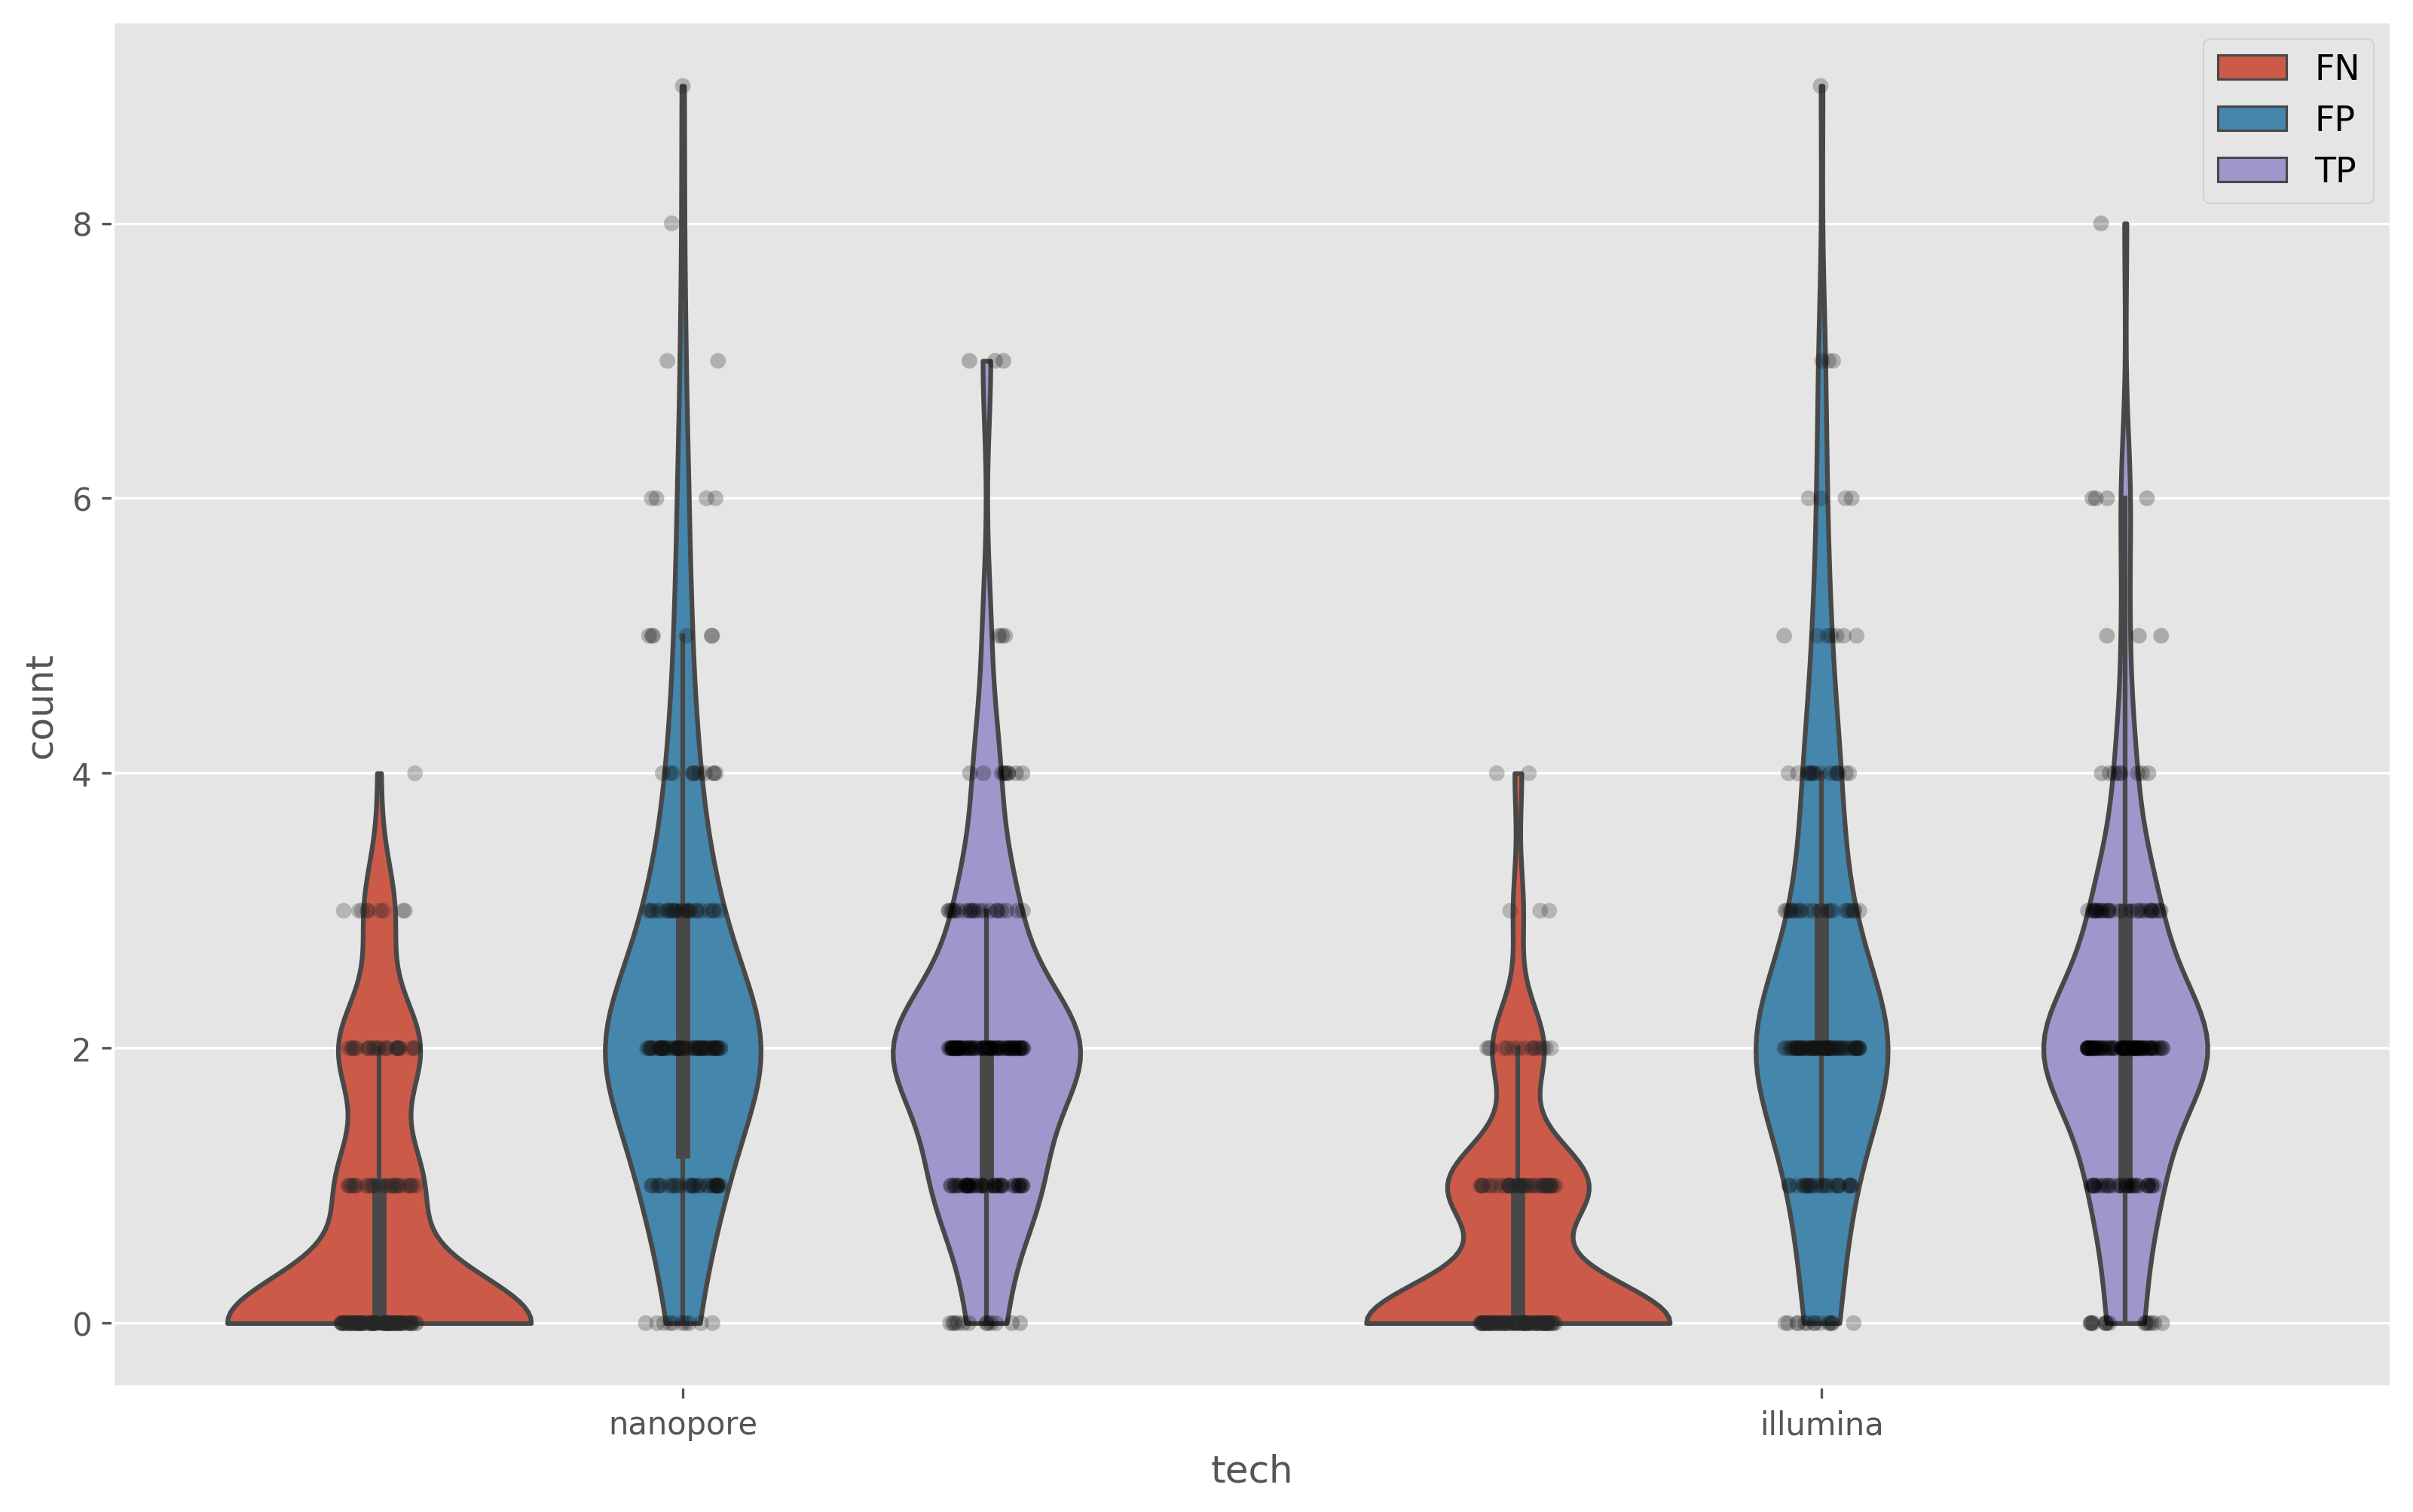

In [201]:
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)
x = "tech"
y = "count"
hue = "classification"
sns.violinplot(data=counts, x=x, y=y, hue=hue, cut=0)
sns.stripplot(data=counts, x=x, y=y, hue=hue, dodge=True, jitter=True, color="black", alpha=0.25)

leghandles, leglabels = ax.get_legend_handles_labels()
ax.legend(leghandles[:-3], leglabels[:-3], loc="best", prop={"size": 11})

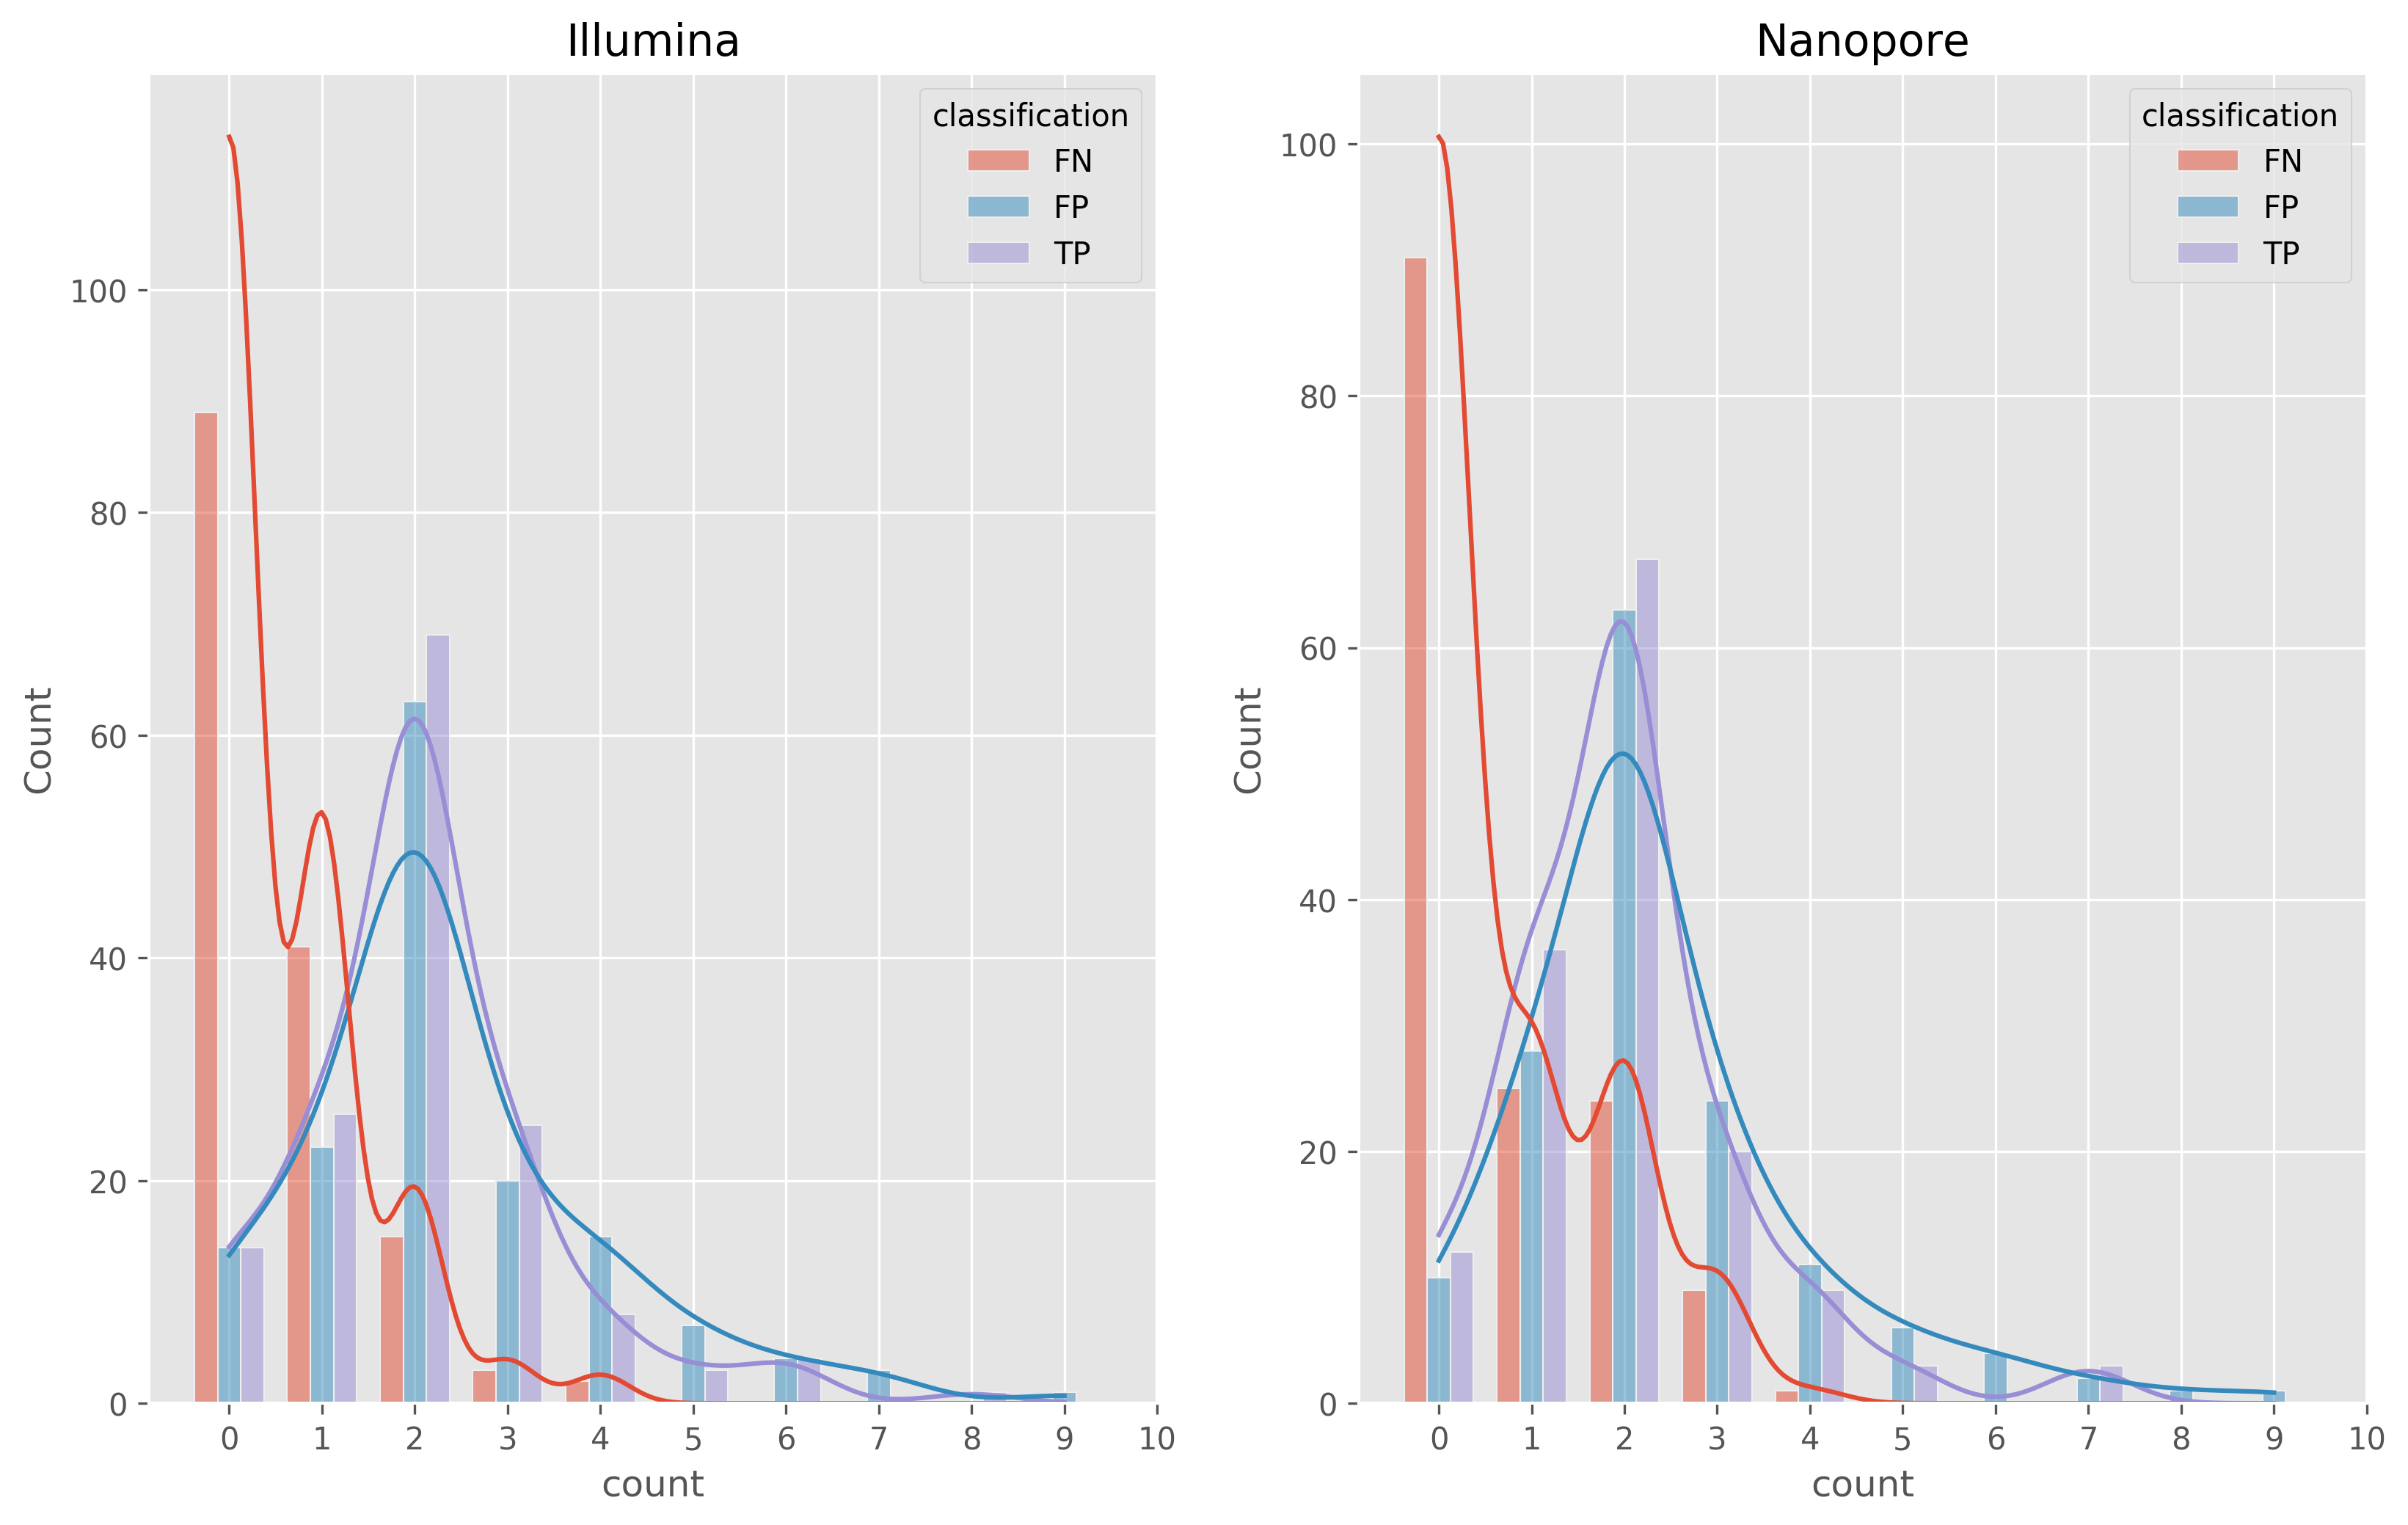

In [202]:
fig, axes = plt.subplots(ncols=2, figsize=FIGSIZE, dpi=DPI)
for ax, tech in zip(axes.flatten(), ["illumina", "nanopore"]):
    x = "count"
    hue = "classification"
    sns.histplot(
        data=counts.query("tech == @tech"), 
        x=x, 
        hue=hue, 
        ax=ax, 
        stat="count", 
        multiple="dodge", 
        discrete=True,
        kde=True,
        shrink=0.75
    )
    ax.set_title(f"{tech.capitalize()}")
    ax.set_xticks(range(11))

In [203]:
counts.groupby(["tech", "classification"]).describe()

count                                              
                         count      mean       std  min   25%  50%  75%  max
tech     classification                                                     
illumina FN              150.0  0.586667  0.852841  0.0  0.00  0.0  1.0  4.0
         FP              150.0  2.386667  1.612812  0.0  2.00  2.0  3.0  9.0
         TP              150.0  2.120000  1.330691  0.0  1.00  2.0  3.0  8.0
nanopore FN              150.0  0.693333  0.989520  0.0  0.00  0.0  1.0  4.0
         FP              150.0  2.366667  1.573338  0.0  1.25  2.0  3.0  9.0
         TP              150.0  2.013333  1.274356  0.0  1.00  2.0  2.0  7.0

In [204]:
from cyvcf2 import VCF
from typing import NamedTuple, Optional, List

In [205]:
class Genotype(NamedTuple):
    allele1: int
    allele2: int

    def is_null(self) -> bool:
        """Is the genotype null. i.e. ./."""
        return self.allele1 == -1 and self.allele2 == -1

    def is_hom(self) -> bool:
        """Is the genotype homozygous"""
        if self.is_null():
            return False
        if self.allele1 == -1 or self.allele2 == -1:
            return True
        return self.allele1 == self.allele2

    def is_het(self) -> bool:
        """Is the genotype heterozyhous"""
        return not self.is_null() and not self.is_hom()

    def is_hom_ref(self) -> bool:
        """Is genotype homozygous reference?"""
        return self.is_hom() and (self.allele1 == 0 or self.allele2 == 0)

    def is_hom_alt(self) -> bool:
        """Is genotype homozygous alternate?"""
        return self.is_hom() and (self.allele1 > 0 or self.allele2 > 0)

    def alt_index(self) -> Optional[int]:
        """If the genotype is homozygous alternate, returns the 0-based index of the
        alt allele in the alternate allele array.
        """
        if not self.is_hom_alt():
            return None
        return max(self.allele1, self.allele2) - 1

    def allele_index(self) -> Optional[int]:
        """The index of the called allele"""
        if self.is_hom_ref() or self.is_null():
            return 0
        elif self.is_hom_alt():
            return self.alt_index() + 1
        else:
            raise NotImplementedError(f"Het Genotype is unexpected: {self}")

    @staticmethod
    def from_arr(arr: List[int]) -> "Genotype":
        alleles = [a for a in arr if type(a) is int]
        if len(alleles) < 2:
            alleles.append(-1)
        return Genotype(*alleles)
    
def is_indel(v):
    empty_alt = not bool(v.ALT)
    gt = Genotype.from_arr(v.genotypes[0])
    if not gt.is_hom_alt():
        return False
    
    rlen = len(v.REF)
    return rlen != len(v.ALT[gt.alt_index()])

In [206]:
columns = ["sample", "tech", "gene", "classification", "count", "is_indel"]

In [207]:
exclude_indels = True
data = []
clf_tag = "VFR_RESULT"
for p in Path("../../results/novel/").rglob("recall.vcf"):
    sample = p.parts[-3]
    tech = p.parts[-5]
    for v in VCF(p):
        if exclude_indels and is_indel(v):
            continue
        gene = v.CHROM
        clf = v.format(clf_tag)[0]
        if "FP" in clf:
            clf = "FN"
        if "TP" in clf:
            clf = "TP"
        data.append((sample, tech, gene, clf, 1, is_indel(v)))

for p in Path("../../results/novel/").rglob("precision.vcf"):
    sample = p.parts[-2]
    tech = p.parts[-4]
    for v in VCF(p):
        if exclude_indels and is_indel(v):
            continue
        gene = v.CHROM
        clf = v.format(clf_tag)[0]
        if "FP" in clf:
            clf = "FP"
        if "TP" in clf:
            clf="TP"
        data.append((sample, tech, gene, clf, 1, is_indel(v)))

In [208]:
df = pd.DataFrame(data, columns=columns)
df.sort_values("gene", inplace=True)

In [209]:
sum(df.is_indel)

0

In [210]:
df.sort_values("gene")

,sample,tech,gene,classification,count,is_indel
883,mada_1-7,nanopore,ahpC,FP,1,False
510,mada_1-43,illumina,ahpC,TP,1,False
502,mada_1-36,illumina,ahpC,TP,1,False
499,mada_122,illumina,ahpC,TP,1,False
495,mada_1-7,illumina,ahpC,TP,1,False
...,...,...,...,...,...,...
37,18_0622446,nanopore,rrs,FN,1,False
304,mada_112,nanopore,rrs,FN,1,False
48,18_0622465,nanopore,rrs,FN,1,False
619,mada_154,illumina,rrs,TP,1,False


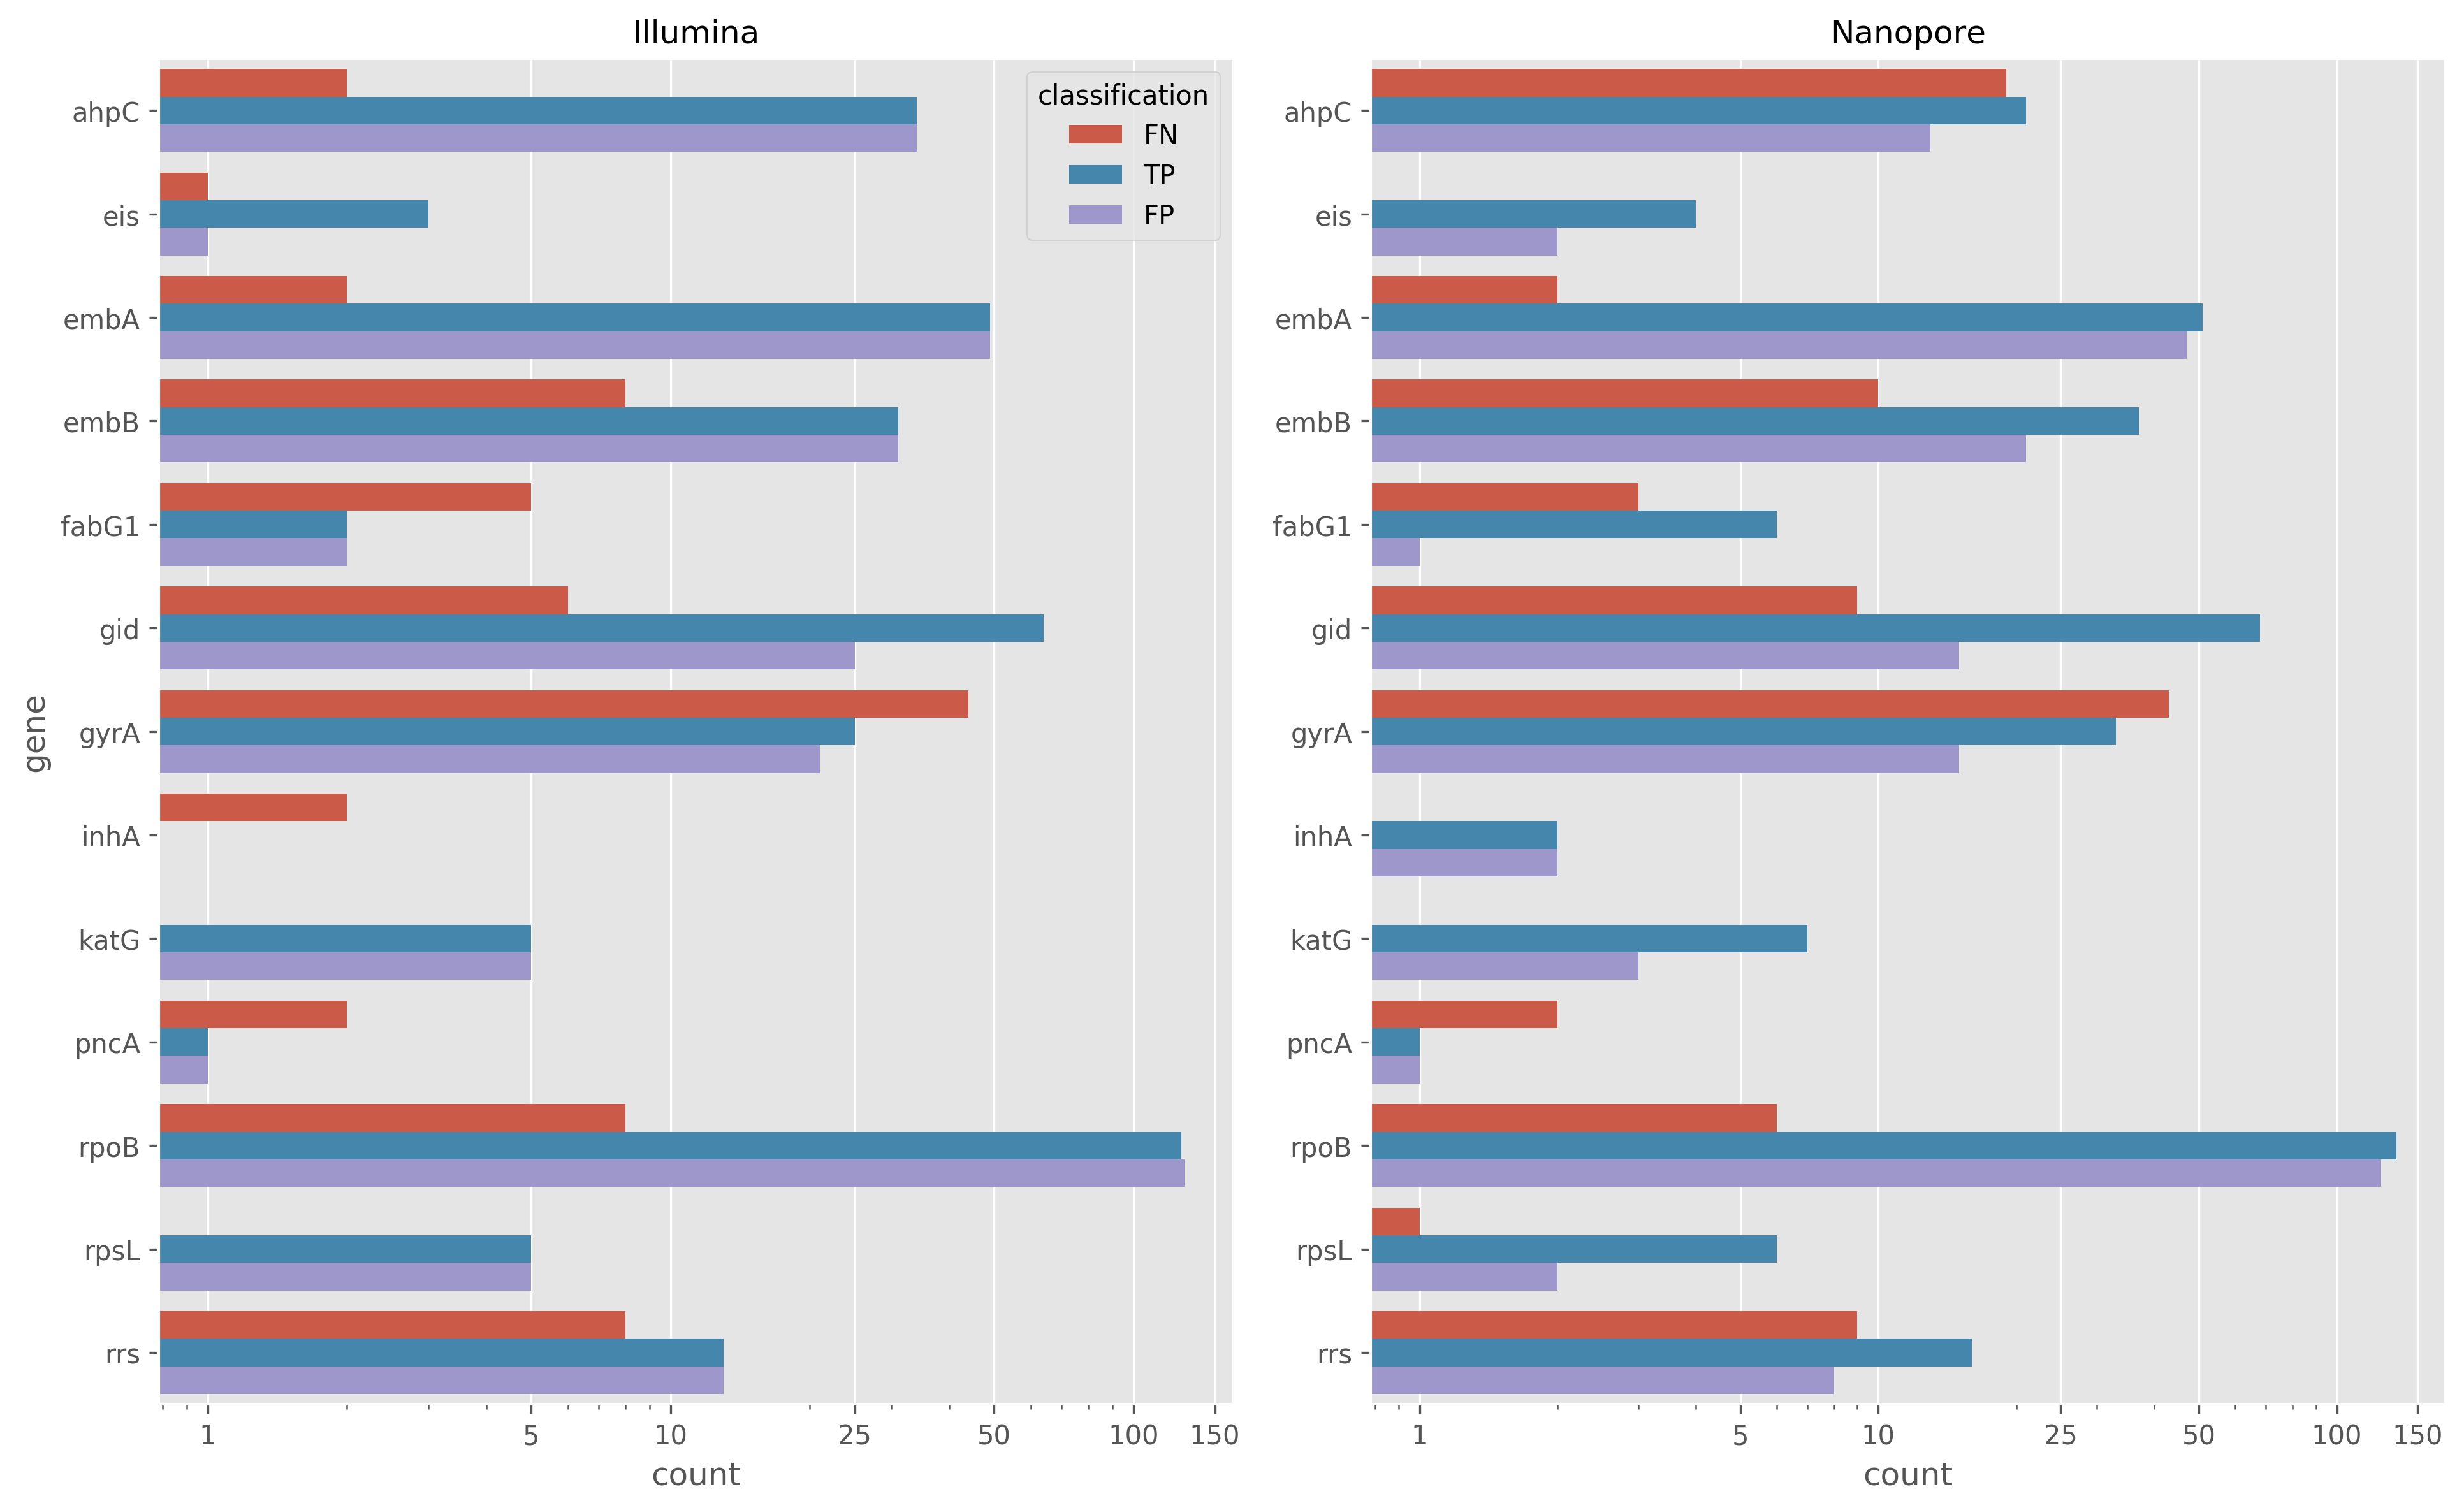

In [211]:
fig, axes = plt.subplots(ncols=2, figsize=FIGSIZE, dpi=DPI)
hue_order = ["FN", "TP", "FP"]
for ax, tech in zip(axes.flatten(), ["illumina", "nanopore"]):
    sns.countplot(data=df.query("tech==@tech"), hue="classification", y="gene", ax=ax, hue_order=hue_order)
    ax.set_title(tech.capitalize(), fontdict=dict(fontsize=12))
    ax.set_xscale("log")
    labels = [1, 5, 10, 25, 50, 100, 150]
    ax.set_xticks(labels)
    ax.set_xticklabels(labels)
ax.set_ylabel("")
ax.get_legend().remove()
plt.tight_layout()

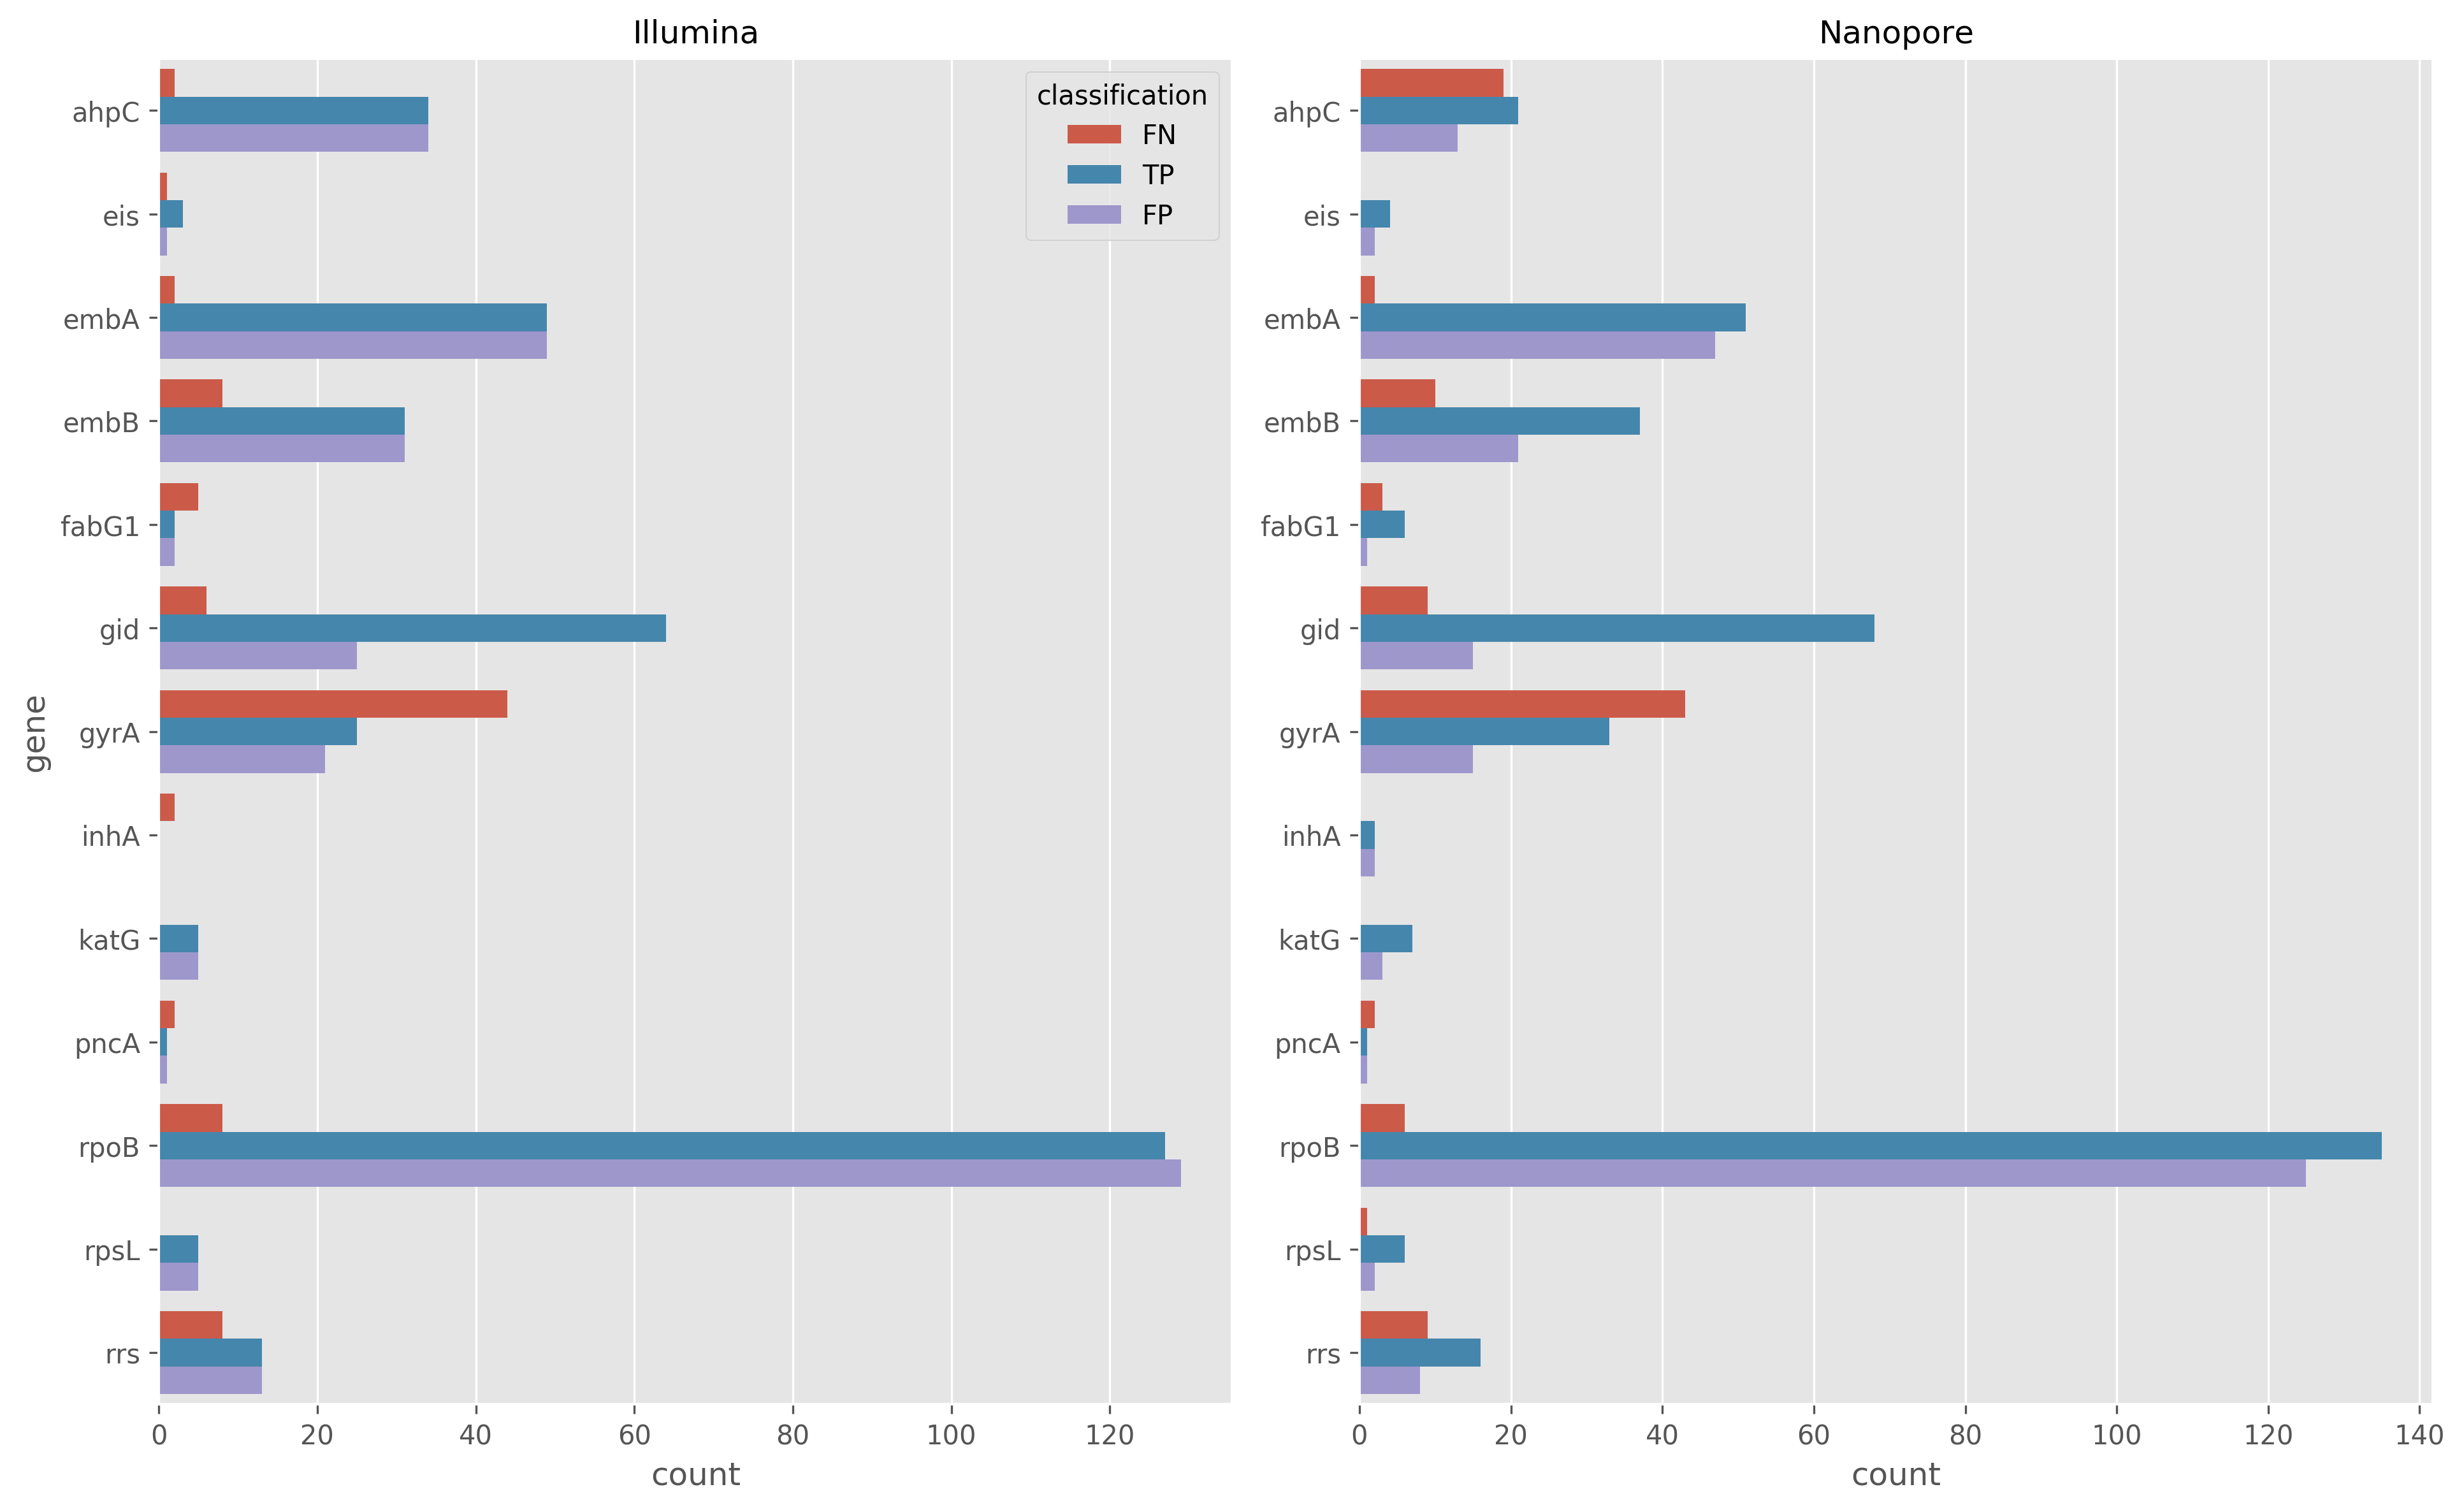

In [212]:
fig, axes = plt.subplots(ncols=2, figsize=FIGSIZE, dpi=DPI)
hue_order = ["FN", "TP", "FP"]
for ax, tech in zip(axes.flatten(), ["illumina", "nanopore"]):
    sns.countplot(data=df.query("tech==@tech"), hue="classification", y="gene", ax=ax, hue_order=hue_order)
    ax.set_title(tech.capitalize(), fontdict=dict(fontsize=12))
    
ax.set_ylabel("")
ax.get_legend().remove()
plt.tight_layout()

In [158]:
def format_cell(cell):
    if isinstance(cell, list):
        if len(cell) == 2:
            return f"{cell[0]} ({cell[1]})" if cell[1] else f"{cell[0]}"
        else:
            return f"{cell[0]}"
    else:
        return cell
    
def recall(row):
    return int(row.TP) / (int(row.TP) + int(row.FN))

def precision(row):
    try:
        return int(row.TP) / (int(row.TP) + int(row.FP))
    except ZeroDivisionError:
        return None

In [161]:
tbl = defaultdict(dict)
for i, row in df.iterrows():
    ix = (row["gene"], row["tech"])
    try:
        tbl[ix][row["classification"]][0] += row["count"]
        tbl[ix][row["classification"]][1] += int(row["is_indel"])
    except KeyError:
        tbl[ix][row["classification"]] = [row["count"], int(row["is_indel"])]
        
tbl = pd.DataFrame(tbl).T.fillna(0).sort_index().applymap(format_cell)
tbl = tbl.reset_index().rename(columns={"level_0": "Gene", "level_1": "Technology"})
tbl["Technology"] = [s.capitalize() for s in tbl["Technology"]]
tbl["Recall"] = tbl.apply(lambda row: recall(row), axis=1)
tbl["Precision"] = tbl.apply(lambda row: precision(row), axis=1)
tex = tbl.to_latex(float_format="%.3f", index=False, na_rep="-")
print(tex)

\begin{tabular}{lllllrr}
\toprule
 Gene & Technology &  TP & FN &  FP &  Recall &  Precision \\
\midrule
 ahpC &   Illumina &  34 &  2 &  34 &   0.944 &      0.500 \\
 ahpC &   Nanopore &  21 & 19 &  13 &   0.525 &      0.618 \\
  eis &   Illumina &   2 &  6 &   1 &   0.250 &      0.667 \\
  eis &   Nanopore &   2 &  6 &   2 &   0.250 &      0.500 \\
 embA &   Illumina &  49 &  2 &  49 &   0.961 &      0.500 \\
 embA &   Nanopore &  51 &  2 &  47 &   0.962 &      0.520 \\
 embB &   Illumina &  31 &  8 &  31 &   0.795 &      0.500 \\
 embB &   Nanopore &  37 & 10 &  21 &   0.787 &      0.638 \\
fabG1 &   Illumina &   2 &  5 &   2 &   0.286 &      0.500 \\
fabG1 &   Nanopore &   6 &  3 &   1 &   0.667 &      0.857 \\
  gid &   Illumina & 135 & 86 &  25 &   0.611 &      0.844 \\
  gid &   Nanopore & 141 & 87 &  15 &   0.618 &      0.904 \\
 gyrA &   Illumina &  25 & 44 &  21 &   0.362 &      0.543 \\
 gyrA &   Nanopore &  33 & 43 &  15 &   0.434 &      0.688 \\
 inhA &   Illumina &   0 & 

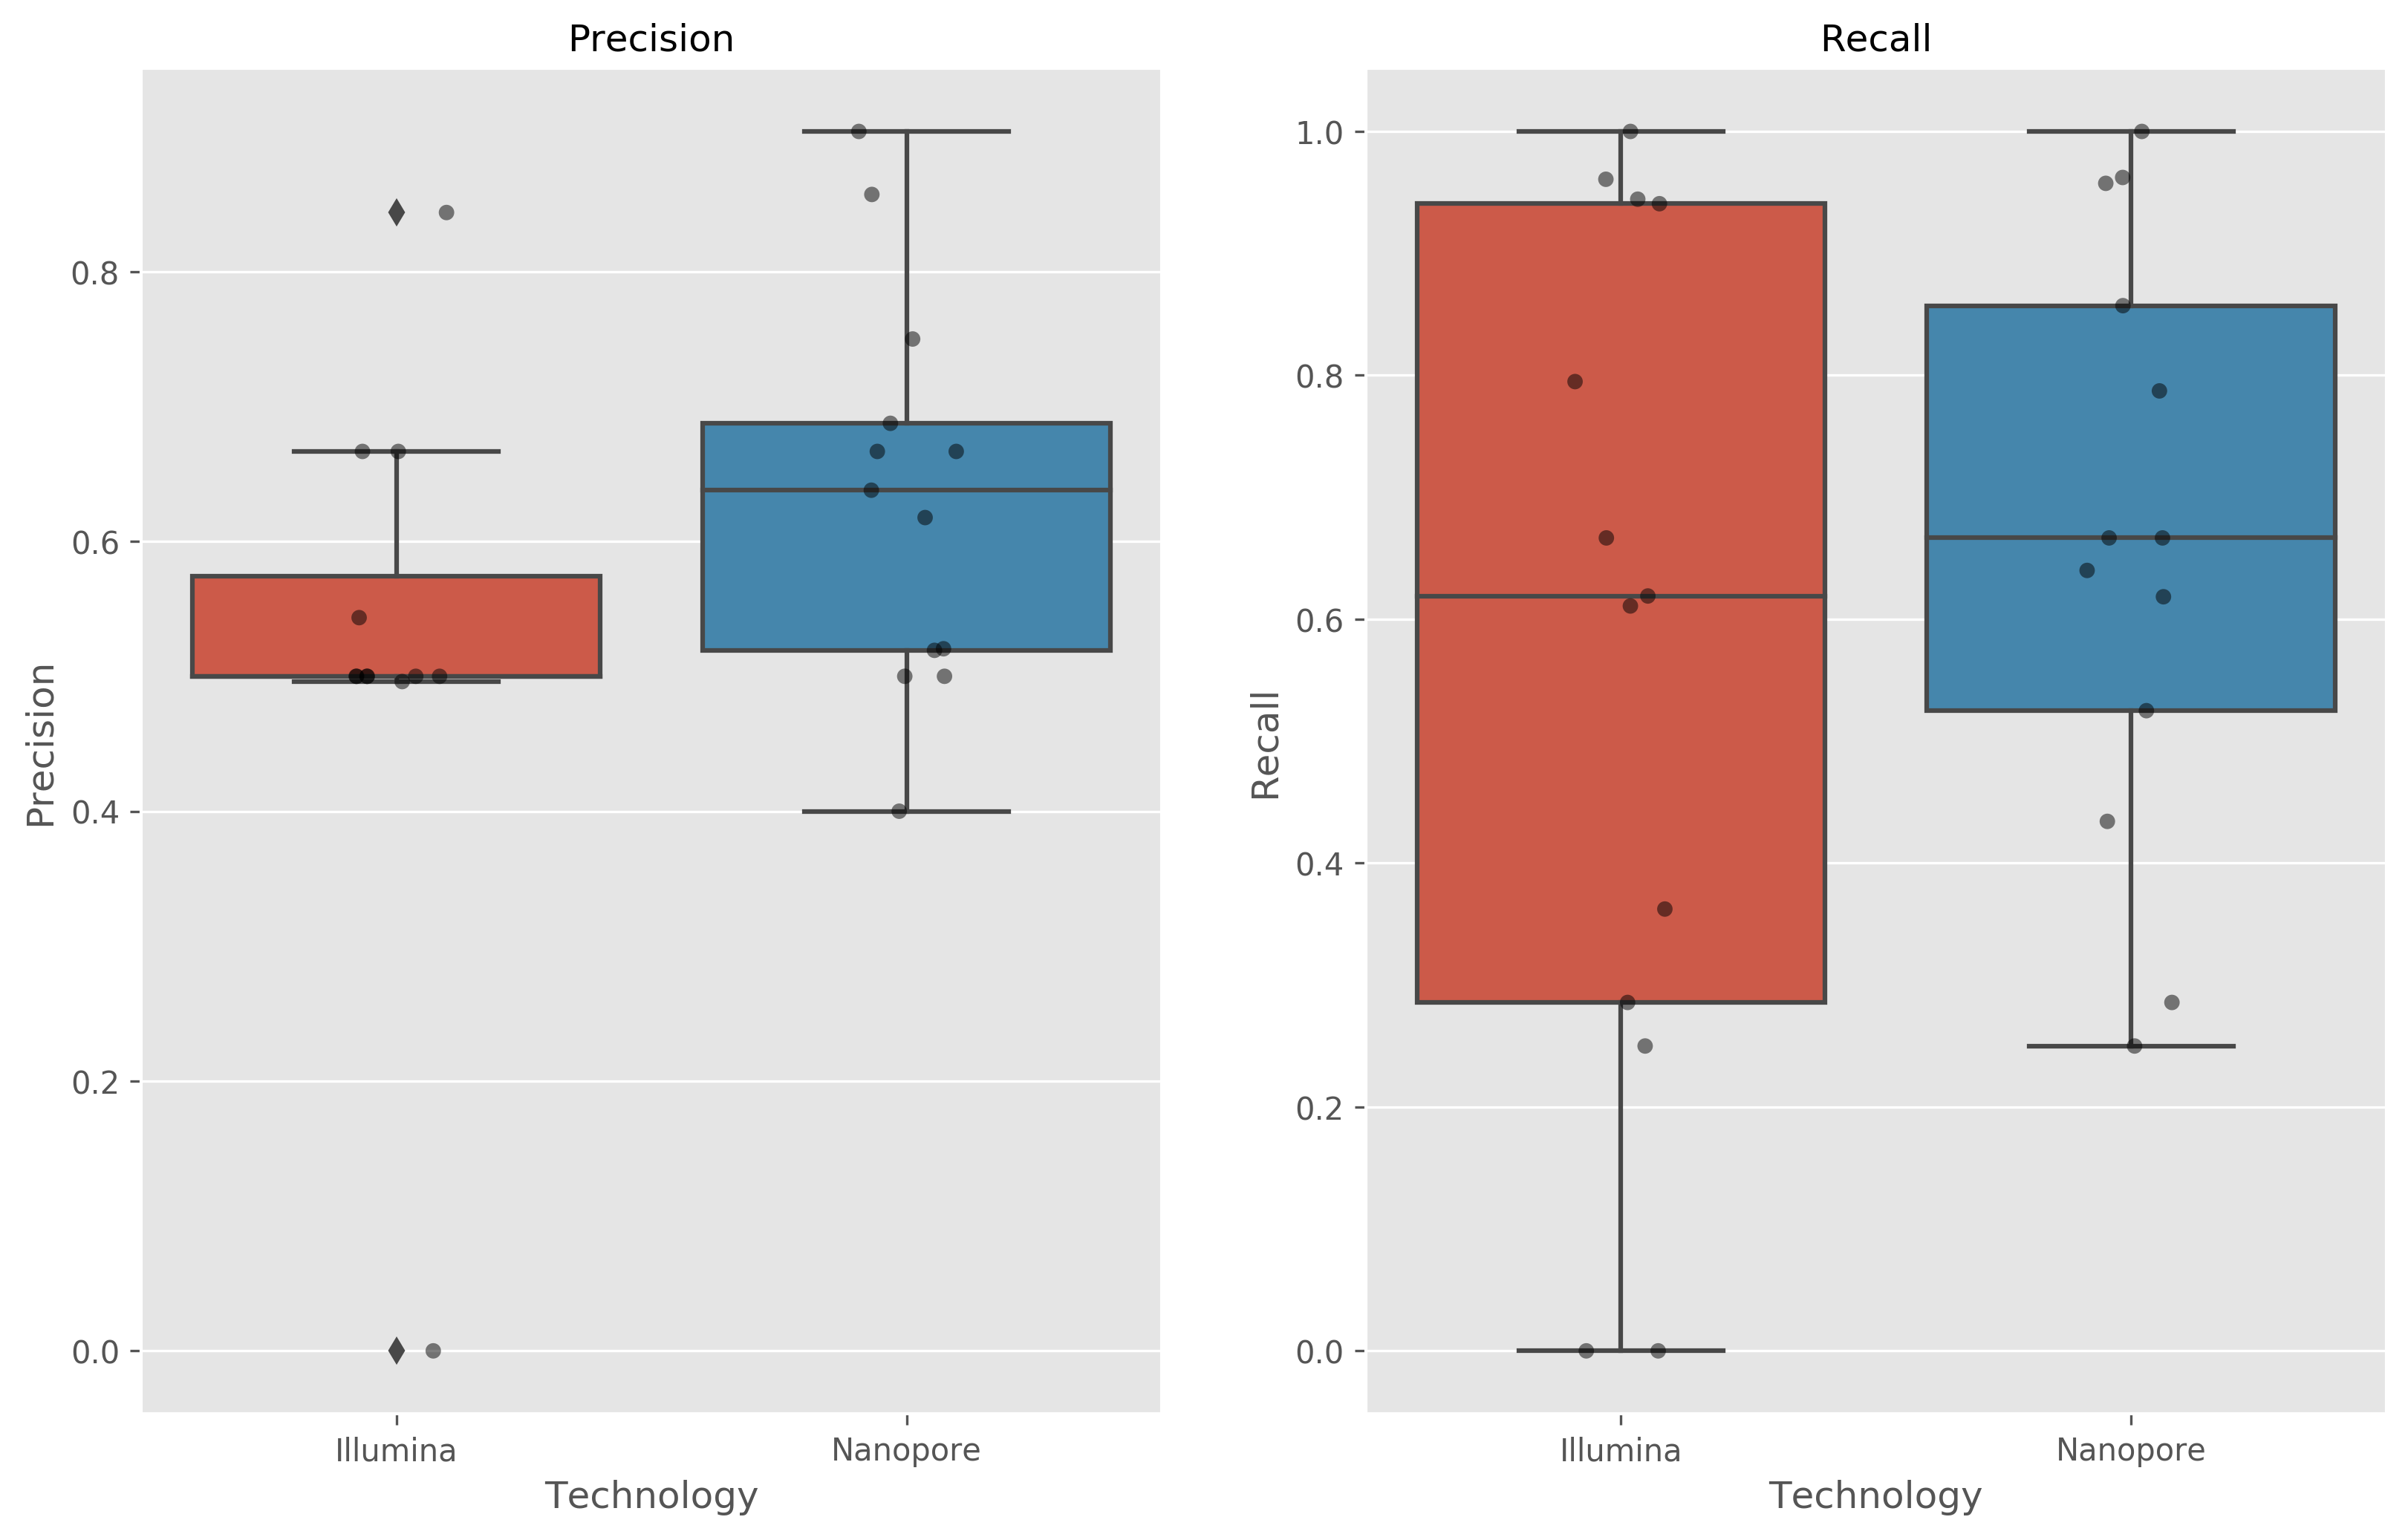

In [176]:
fig, axes = plt.subplots(ncols=2, figsize=FIGSIZE, dpi=DPI)
hue_order = ["FN", "TP", "FP"]
for ax, metric in zip(axes.flatten(), ["Precision", "Recall"]):
    sns.boxplot(data=tbl, x="Technology", y=metric, ax=ax, )
    sns.stripplot(data=tbl, x="Technology", y=metric, ax=ax, color="black", alpha=0.5)
    ax.set_title(metric.capitalize(), fontdict=dict(fontsize=12))

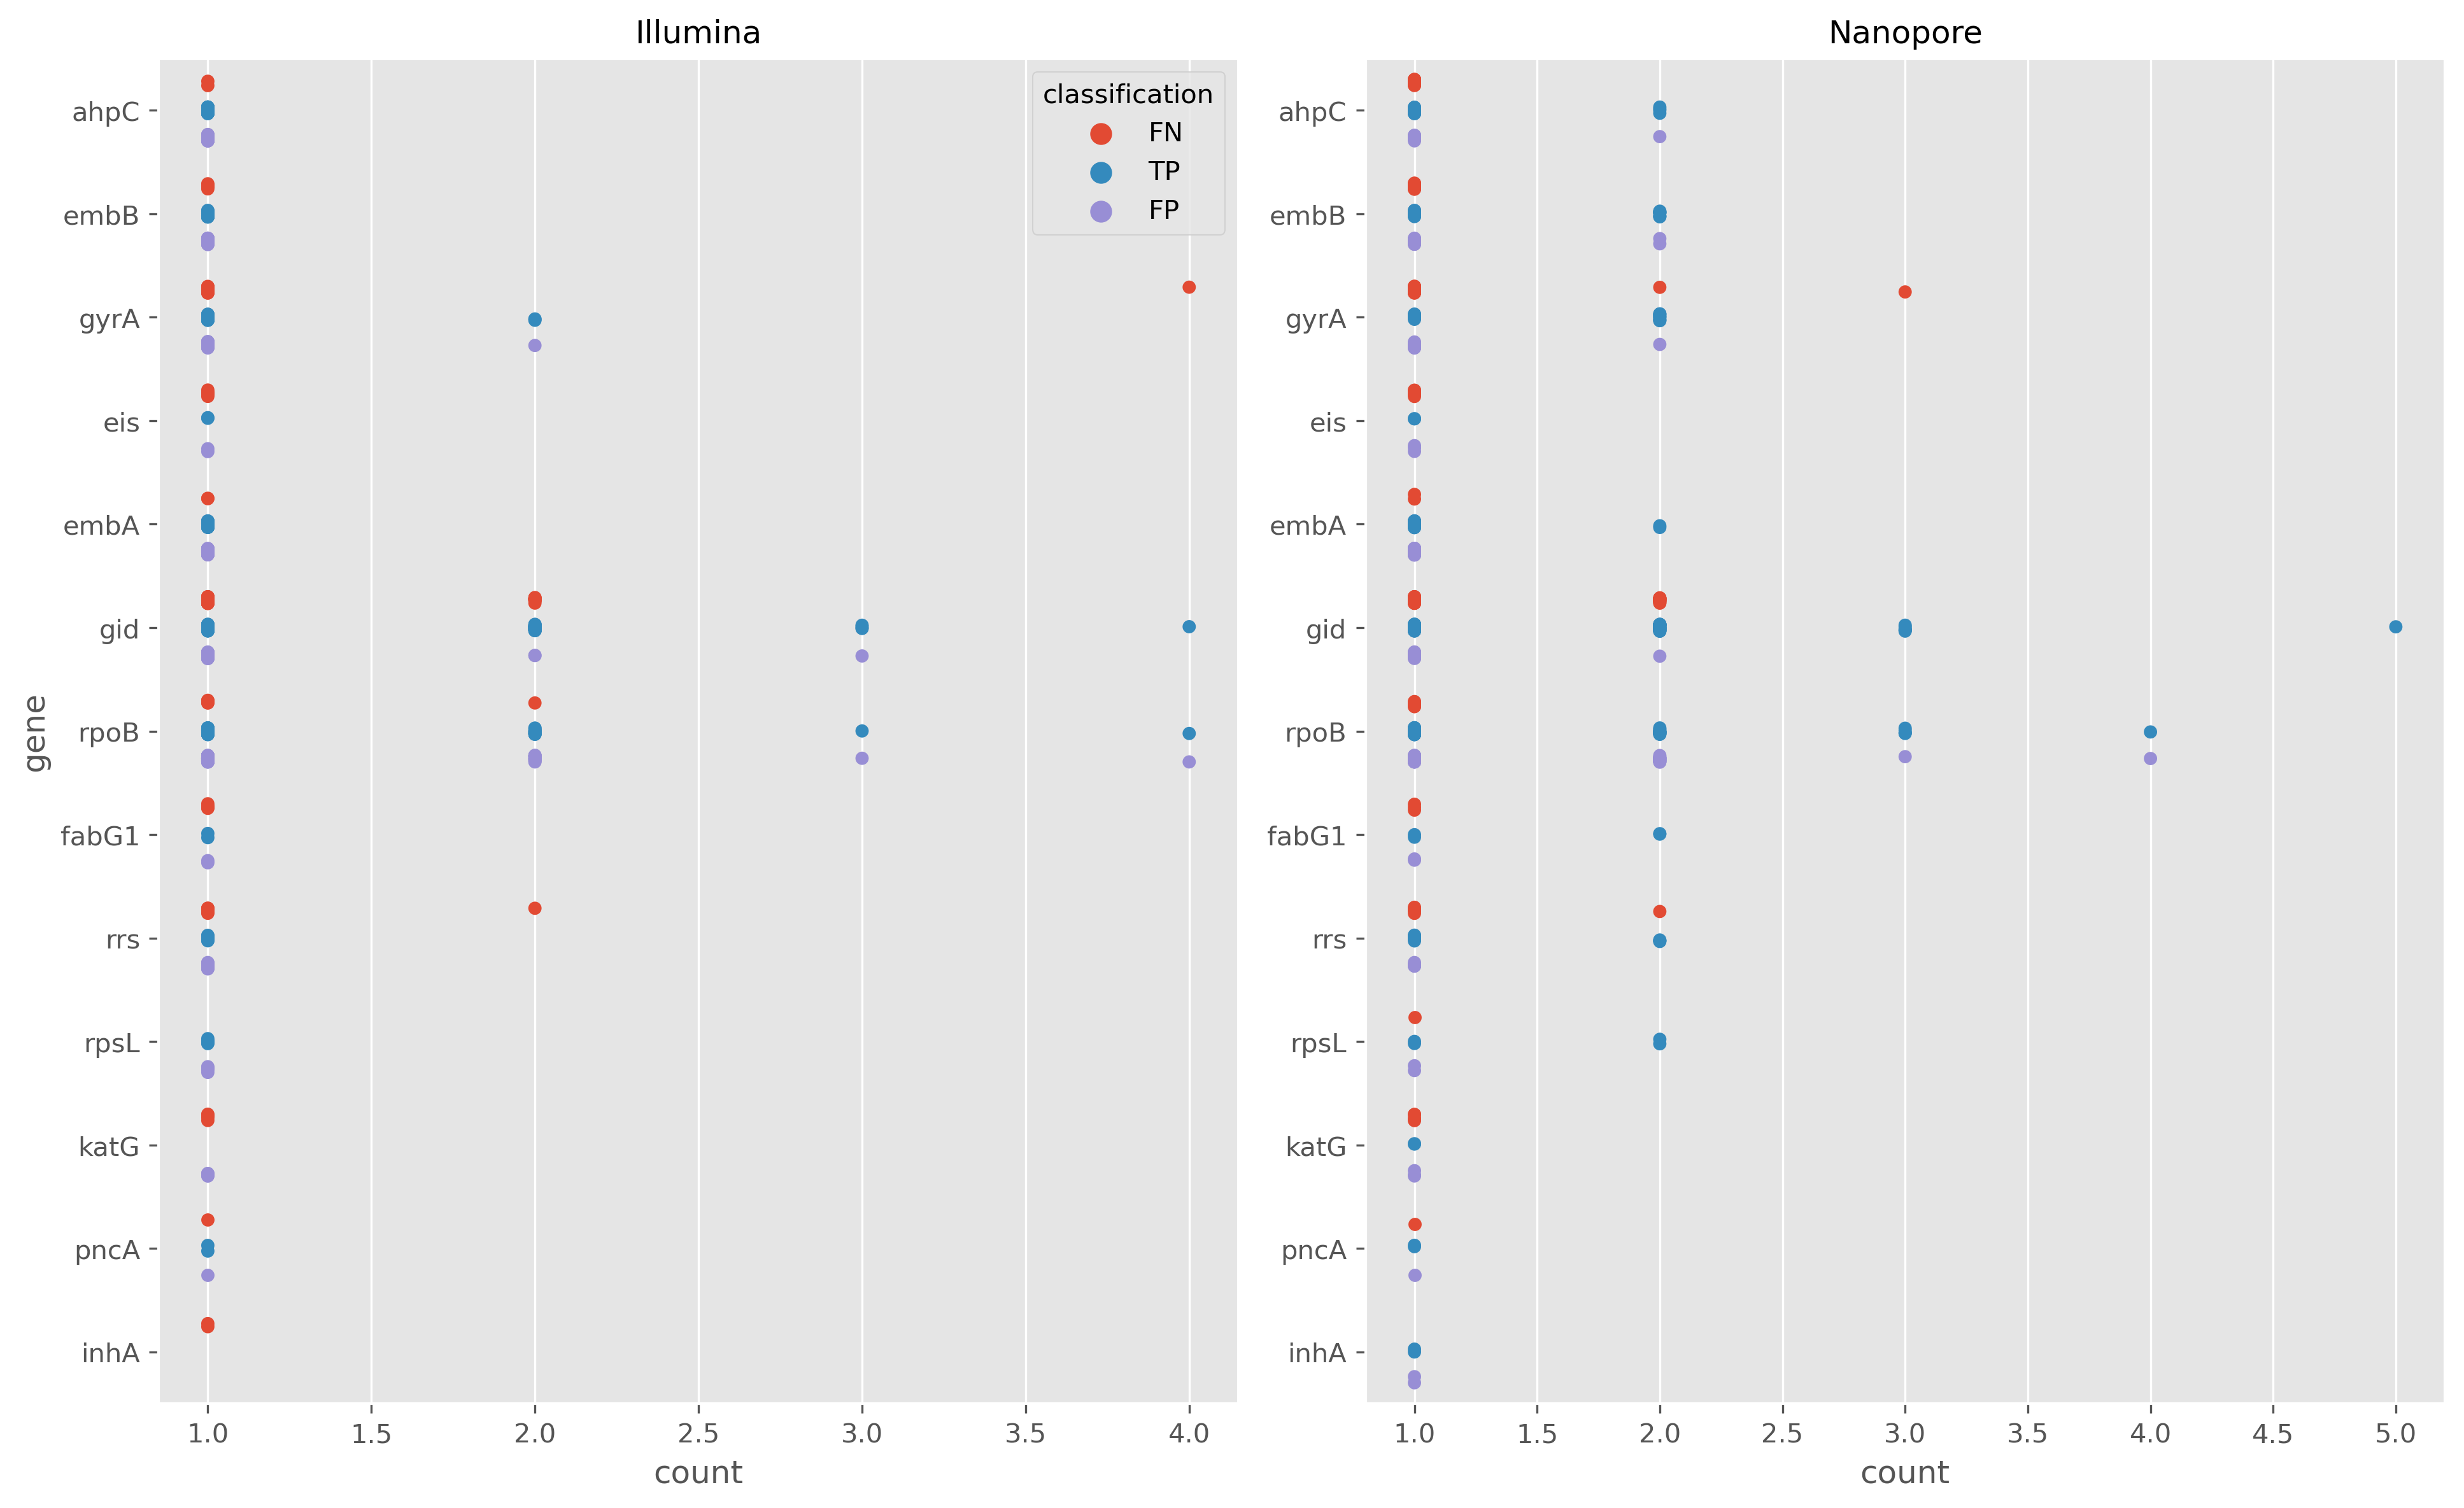

In [29]:
fig, axes = plt.subplots(ncols=2, figsize=FIGSIZE, dpi=DPI)
hue_order = ["FN", "TP", "FP"]
for ax, tech in zip(axes.flatten(), ["illumina", "nanopore"]):
    sns.stripplot(data=g.query("tech==@tech"), dodge=True,hue="classification", y="gene", ax=ax, hue_order=hue_order, x="count")
    ax.set_title(tech.capitalize(), fontdict=dict(fontsize=12))
ax.set_ylabel("")
ax.get_legend().remove()
plt.tight_layout()

In [38]:
df.groupby(["tech"])["is_indel"].describe()

,count,unique,top,freq
tech,,,,
illumina,561,1,False,561
nanopore,561,1,False,561
